

## **Loading Dataset from Drive**

In [1]:
from google.colab import drive,files
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "drive/My Drive/Dataset.zip" 
!ls



**Function to Load Dataset into memory**

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sn
import cv2

In [0]:
def loadDataset():
    dir = os.listdir('Dataset')
    X=[];
    y=[];

    for class_name in dir:

        files =os.listdir(os.path.join('Dataset',class_name))
        for f in files:
            if(f[-3:]=='png' or f[-3:]=='jpg'):
                X.append(os.path.join('Dataset',class_name,f))
                y.append(class_name)
                
    return pd.DataFrame({"path":X,"labels":y})


In [0]:
CLASSES=['handguns','razor blades','shurikens']

mapping={
    'handguns':0,
    'razor blades':1,
    'shurikens':2
   
}
NUM_CLASSES=len(CLASSES)

In [9]:
df=loadDataset()
print(df.head())
print(df['labels'].value_counts())

                                 path     labels
0   Dataset/shurikens/shurikens71.jpg  shurikens
1  Dataset/shurikens/shurikens740.jpg  shurikens
2  Dataset/shurikens/shurikens624.jpg  shurikens
3  Dataset/shurikens/shurikens278.jpg  shurikens
4   Dataset/shurikens/shurikens26.jpg  shurikens
handguns        1000
shurikens       1000
razor blades    1000
Name: labels, dtype: int64


## **Getting Original GoogleNet Model and ImageNet weights**

### `Import required modules`

In [10]:
from keras.applications import InceptionV3
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from keras import optimizers

from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D,AveragePooling2D
import os
import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


Using TensorFlow backend.


## **Training** **Section**

In [0]:

INPUT_SIZE = (299,299)
def GoogleNet(NUM_CLASSES,freeze_layers=1):

    base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(299,299,3))
    x = base_model.output
    x=GlobalAveragePooling2D()(x)
   
    preds = Dense(NUM_CLASSES, activation='softmax')(x)
   
    # Create model
    model = Model(inputs=base_model.input, outputs=preds)

    # Freeze Layers for transfer learning 
    freeze_layers = -1*freeze_layers
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[freeze_layers:]:
        layer.trainable = True
   
    return model


def startTraining(model, train_aug_df, val_df, BATCH_SIZE=32, epochs=10, checkpoint_path='weights'):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_aug_df,
        x_col="path",
        y_col="labels",
        target_size=INPUT_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="path",
        y_col="labels",
        target_size=INPUT_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    model.compile(optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    #
    try:
      os.mkdir(checkpoint_path)
    except:
      pass
    checkpoint_path = checkpoint_path + "/cp-{epoch:04d}.hdf5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1,
        save_weights_only=False,
        period=1)

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int(train_aug_df.shape[0] / (BATCH_SIZE)),
        epochs=epochs,
        callbacks=[cp_callback],
        validation_data=validation_generator,
        validation_steps=int(val_df.shape[0] / (BATCH_SIZE))
    )
    print(history.history.keys())
    return history


### **Start Training**

In [12]:

df = loadDataset()
train, val = train_test_split(df, test_size=0.20, random_state=42)
print(train.shape)
print(val.shape)
model = GoogleNet(NUM_CLASSES,15);
model.summary()



(2400, 2)
(600, 2)
87916544/87910968 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________

In [0]:
history = startTraining(model, train, val, epochs=15)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Epoch 1/15
75/75 [==============================] - 238s 3s/step - loss: 1.0925 - accuracy: 0.3879 - val_loss: 1.0926 - val_accuracy: 0.4236

Epoch 00001: saving model to weights/cp-0001.hdf5
Epoch 2/15
75/75 [==============================] - 227s 3s/step - loss: 1.0491 - accuracy: 0.4454 - val_loss: 0.9872 - val_accuracy: 0.4120

Epoch 00002: saving model to weights/cp-0002.hdf5
Epoch 3/15
75/75 [==============================] - 215s 3s/step - loss: 1.0045 - accuracy: 0.5125 - val_loss: 0.9936 - val_accuracy: 0.5106

Epoch 00003: saving model to weights/cp-0003.hdf5
Epoch 4/15
75/75 [==============================] - 213s 3s/step - loss: 0.9710 - accuracy: 0.5583 - val_loss: 0.9001 - val_accuracy: 0.5194

Epoch 00004: saving model to weights/cp-0004.hdf5
Epoch 5/15
75/75 [==============================] - 213s 3s/step - loss: 0.9417 - accuracy: 0.5892 - val_loss: 

### Visualize Training Graphs

In [0]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'test acc', 'train loss', 'test loss'], loc='upper left')

plt.show()

Save model weights in Gdrive

In [0]:
!zip -r "drive/My Drive/weights.zip" "weights"
print("weights.zip file uploaded on your google drive. Kindly check your google drive")


## **Inference Section**

In [0]:
def plotConfusionMatrix(mat):

    # Normalise
    # normalized_mat = mat.astype('float') /mat.sum(axis=1)[:, np.newaxis]


    df_cm = pd.DataFrame(mat,index=CLASSES,columns=CLASSES)
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=0.8)  # for label size
    sn.heatmap(df_cm, annot=True,fmt='d', cbar=False)  # font size

    plt.show()
def inferenceImage(model,path):
    img = load_image(img_path=path,expand_dim=True)
    p=model.predict(img)
    predicted_class=CLASSES[np.argmax(p)]
  
    return predicted_class


def load_image(img_path,expand_dim=False ):
    img = image.load_img(img_path, target_size=INPUT_SIZE)
    img_array = image.img_to_array(img)
    if(expand_dim):
        img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)
def evaluateOnDataFrame(model,df):
    predictions = [];
    img_paths = list(df.loc[:, 'path'])
    truth=list(df.loc[:,'labels'])
    i=0;
    print(df['labels'].value_counts())
  
    for path in img_paths:
        x = load_image(path,expand_dim=True)
        truth[i]=mapping[truth[i]]
        p=model.predict(x)
        p=np.argmax(p)
        predictions.append(p)
        i=i+1;
   
    accuracy = accuracy_score(truth,predictions)
    confusion_mat=confusion_matrix(truth,predictions)
    precsion, recall, f1_ccore, _ = precision_recall_fscore_support(truth, predictions)
    print("Total Accuracy :",round(accuracy*100,2))
    print("Precision :", (precsion*100))
    print("Recall :",(recall*100))
    print("Handguns Accuracy :", round(f1_ccore[0]*100,2))
    print("razor_blades Accuracy :",round(f1_ccore[1]*100,2))
    print("shurikens Accuracy :", round(f1_ccore[2]*100,2))
    plotConfusionMatrix(confusion_mat)


### **Evaluate on Test Data**

In [14]:
# Download weights from gDrive
!unzip "drive/My Drive/weights.zip" 

Archive:  drive/My Drive/weights.zip
   creating: weights/
  inflating: weights/cp-0015.hdf5    
  inflating: weights/cp-0009.hdf5    
  inflating: weights/cp-0013.hdf5    
  inflating: weights/cp-0001.hdf5    
  inflating: weights/cp-0012.hdf5    
  inflating: weights/cp-0007.hdf5    
  inflating: weights/cp-0008.hdf5    
  inflating: weights/cp-0011.hdf5    
  inflating: weights/cp-0004.hdf5    
  inflating: weights/cp-0002.hdf5    
  inflating: weights/cp-0005.hdf5    
  inflating: weights/cp-0006.hdf5    
  inflating: weights/cp-0010.hdf5    
  inflating: weights/cp-0014.hdf5    
  inflating: weights/cp-0003.hdf5    


In [0]:
# load weights
model = GoogleNet(len(CLASSES))
weights_path='weights/cp-0013.hdf5'
model.load_weights(weights_path)

shurikens       217
razor blades    197
handguns        186
Name: labels, dtype: int64
Total Accuracy : 63.0
Precision : [66.66666667 51.7699115  72.58883249]
Recall : [63.44086022 59.39086294 65.89861751]
Handguns Accuracy : 65.01
razor_blades Accuracy : 55.32
shurikens Accuracy : 69.08


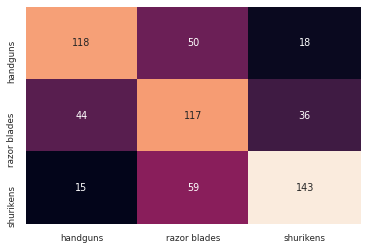

In [17]:
evaluateOnDataFrame(model,val)

In [0]:
from math import sqrt
def plot_images(images, cls_true, cls_pred=None):

    # Create figure with 3x3 sub-plots.
    count = len(images)
    fig, axes = plt.subplots(int(sqrt(count)), int(sqrt(count)))
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def testRandom(model,df,count =16):
  idx=np.random.randint(0,df.shape[0],count)
  file_path_list=list(df.loc[idx,'path'])
  true_labels =list(df.loc[idx,'labels'])

  img_list =[];
  predicted_labels=[]
  for file_path in file_path_list:
      img = cv2.imread(file_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img_list.append(img)
      prediction=inferenceImage(model,file_path)
      predicted_labels.append(prediction)

  plot_images(img_list,true_labels,predicted_labels)
    

In [0]:
testRandom(model,df,count=4)